# Classification Pump-iT-Up | Random Forest Classifier
_**Classification with AWS**_
---
---

1. [Imports](#Imports)
1. [Data](#Data)
1. [Feature-engineering](#Feature-engineering)
1. [PCA](#PCA)
1. [Train](#Train)
    1. Setup Hyperparamter Tuning
    1. Trai the model
1. [Accuracy](#Accuracy)
    1. Confussion matrix
    1. Classification report
1. [Submission](#Submission)

# Imports

In [1]:
%load_ext autoreload
%autoreload 1

from __future__ import print_function

# STD lib imports
import os
import sys

# Third party libs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

PROJ_ROOT = os.path.join(os.pardir)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)

# import my method from the source code
%aimport features.build_features
import features.build_features as bf

print(os.path.abspath(PROJ_ROOT))

/Users/miguelcaballero/Documents/Others/DataDriven/pump_it_up


# Data
## Exploration | Refinement

In [2]:
## Try adding parameter index=0
pump_data_path_df = os.path.join(PROJ_ROOT,
                              "data",
                              "raw",
                              "training_set_values.csv")

pump_data_path_la = os.path.join(PROJ_ROOT,
                              "data",
                              "raw",
                              "training_set_labels.csv")

# remove columns, NaN's and assign types
df_clean, df_raw = bf.remove_invalid_data(pump_data_path_df, pump_data_path_la)
print(df_clean.shape)

(16132, 20)


(16132, 20)
False


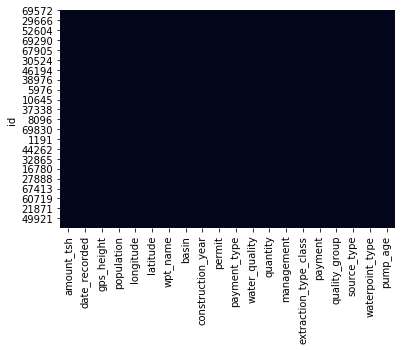

In [3]:
# Separate the data
labels = bf.encode_label(df_clean.iloc[:,-1]) 
df = df_clean.iloc[:,:-1]

# change types
df['permit'] = df['permit'].astype('bool')

# add columns
df['pump_age'] = 2018 - df['construction_year']

# review data quality (no NaN's)
print(df.shape)
print(df.isnull().values.any())
sns.heatmap(df.isnull(), cbar=False)

# Feature-engineering

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

# Categorical columns
columns = df.columns[df.dtypes == 'category'].tolist()

# Feature engineering pipeline
pipeline_feature_engineering = Pipeline([('features', FeatureUnion(n_jobs=1, transformer_list=[
                                            # booleans
                                            ('boolean', Pipeline([
                                                ('selector', bf.type_selector('bool')),
                                            ])), 
                                            # Numericcals
                                            ('numericals', Pipeline([
                                                ('selector', bf.type_selector(np.number)),
                                                ('scaler', MinMaxScaler()),
                                            ])),

                                            # Categoricals
                                            ('categoricals', Pipeline([
                                                ('selector', bf.type_selector('category')),
                                                ('labeler', bf.string_indexer()),
                                                ('encoder', bf.add_features(columns)),
                                                ]))
                                            ])),
                                        ])

# Apply feature engineering pipeline
df_train = pipeline_feature_engineering.fit_transform(df, labels)
print(pd.DataFrame(df_train).shape)
pd.DataFrame(df_train).head()

(16132, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.023999,0.593546,0.009422,0.496455,0.169889,0.730769,0.269231,38.0,11495.0,...,0.054612,0.152678,0.900694,0.684788,0.614493,0.527089,0.152678,0.900694,0.298971,0.625341
1,1.0,0.000099,0.305964,0.021724,0.731374,0.741675,0.923077,0.076923,198.0,4848.0,...,0.209088,0.411604,0.900694,0.684788,0.614493,0.527089,0.411604,0.900694,0.008926,0.136251
2,1.0,0.000079,0.025735,0.000000,0.890819,0.652211,0.923077,0.076923,37.0,11173.0,...,0.209088,0.411604,0.077858,0.684788,0.614493,0.203757,0.411604,0.083189,0.001922,0.136251
3,0.0,0.000799,0.459559,0.021724,0.573952,0.101876,0.500000,0.500000,191.0,1961.0,...,0.054612,0.057897,0.900694,0.235681,0.062856,0.192351,0.057897,0.900694,0.126891,0.206050
4,1.0,0.001999,0.721405,0.002966,0.468922,0.240961,0.326923,0.673077,83.0,3899.0,...,0.225824,0.360402,0.900694,0.038805,0.086164,0.527089,0.360402,0.900694,0.300335,0.625341


# PCA

In [5]:
# principal component analysis
pca = PCA(n_components=2, svd_solver='full')
principalComponents = pca.fit_transform(df_train)

df_pca = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
df_pca = pd.concat([df_pca, bf.decode_label(labels.reset_index(drop=True))], axis = 1)
print("Explained_Variance_Ratio: {}".format(sum(pca.explained_variance_ratio_)))

Explained_Variance_Ratio: 0.9999981507640385


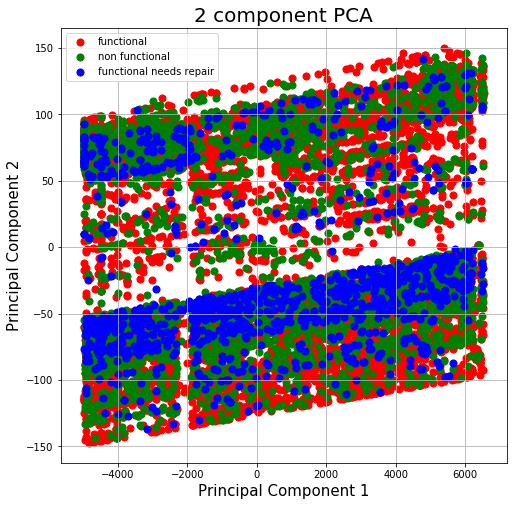

In [6]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['functional', 'non functional', 'functional needs repair']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca['status_group'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC1']
               , df_pca.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Train
## Tunning paramters

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = { 
            'n_estimators': [400, 500, 550],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [10,15,20,30,40,50],
            'criterion' :['gini', 'entropy']
            }

# Create a based model
rfc = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(df_train, labels)
CV_rfc.best_params_

## Train the model

In [7]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df_train, labels, test_size=0.2, random_state=42)
print(X_train.shape)


#clf = LogisticRegression(C=100, solver='lbfgs', max_iter=80000, multi_class='multinomial')
clf =  RandomForestClassifier(random_state = 42, 
                              max_features='auto', 
                              n_estimators= 500, 
                              max_depth=20, 
                              criterion='entropy')
    
clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(12905, 32)
CPU times: user 9.5 s, sys: 66.2 ms, total: 9.56 s
Wall time: 9.56 s


In [8]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred)) 

0.8320421444065695


# Accuracy

## Confussion matrix

Confusion matrix, without normalization


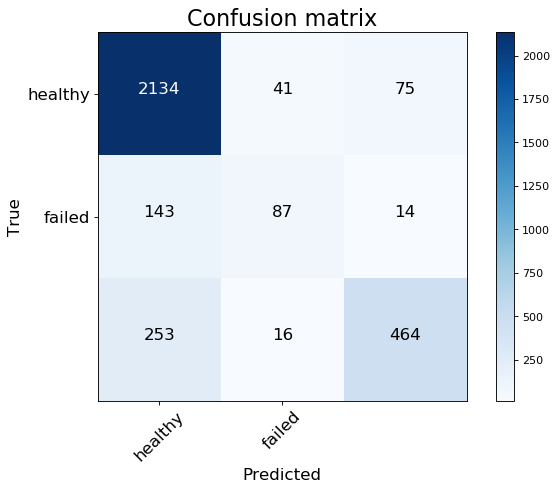

In [9]:
%matplotlib inline

# Third party libs
from sklearn.metrics import confusion_matrix

# import my method from the source code
%aimport visualization.visualize
import visualization.visualize as plt

# confusion matrix
cm = confusion_matrix(y_test, clf.predict(X_test))

# plot
plt.plot_confusion_matrix(cm,['healthy','failed'])

## Classification report

In [10]:
from sklearn.metrics import classification_report

print(accuracy_score(y_test, clf.predict(X_test)))
report = classification_report(y_test, clf.predict(X_test))
print(report)

0.8320421444065695
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      2250
          1       0.60      0.36      0.45       244
          2       0.84      0.63      0.72       733

avg / total       0.82      0.83      0.82      3227



In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.82384824 0.81480046 0.81518791 0.82054264 0.82674419]
Mean: 0.8202246873572058
Standard Deviation: 0.004701624725889685


# Submission

## Start the process

In [12]:
# Load test set
test_values = os.path.join(PROJ_ROOT,
                              "data",
                              "raw",
                              "test_set_values.csv")

df = bf.remove_columns(test_values)

# change type of permit to boolean
df['permit'] = df['permit'].astype('bool')
df[['permit']] = df[['permit']].fillna(value=True)

# add columns
df['pump_age'] = 2018 - df['construction_year']

In [13]:
print(df.shape)
#df.head()

(14850, 20)


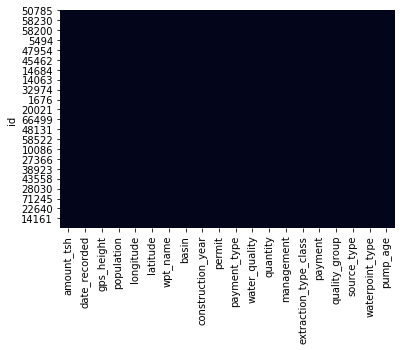

In [14]:
sns.heatmap(df.isnull(), cbar=False)

In [40]:
# Apply feature engineering pipeline
df_test = pipeline_feature_engineering.transform(df)
df_test[np.isnan(df_test)] = 0

y_pred = clf.predict(df_test)
result = df[['population', 'permit']]
result['status_group'] = bf.decode_label(y_pred).values
result = result.drop(columns=['population', 'permit'])
result.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,status_group
id,
50785,non functional
51630,functional
17168,non functional
45559,non functional
49871,functional


In [41]:
result.to_csv('/Users/miguelcaballero/Documents/Others/DataDriven/pump_it_up/data/raw/result.csv')

In [42]:
# should be 14850
len(result)

14850

# Result 0.7277

In [44]:
print(accuracy_score(y_test, clf.predict(X_test))) 

0.8320421444065695


In [45]:
print(report)

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      2250
          1       0.60      0.36      0.45       244
          2       0.84      0.63      0.72       733

avg / total       0.82      0.83      0.82      3227



In [46]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.82384824 0.81480046 0.81518791 0.82054264 0.82674419]
Mean: 0.8202246873572058
Standard Deviation: 0.004701624725889685
